Training Original Mini-GPT...
Epoch 0, Loss 3.5052
Epoch 50, Loss 1.7916
Epoch 100, Loss 0.8522
Epoch 150, Loss 0.4323
Epoch 200, Loss 0.3096
Epoch 250, Loss 0.2570
Epoch 300, Loss 0.3610
Epoch 350, Loss 0.3327
Epoch 400, Loss 0.2502
Epoch 450, Loss 0.2790
Epoch 500, Loss 0.2522
Epoch 550, Loss 0.3385
Epoch 600, Loss 0.1939
Epoch 650, Loss 0.2478
Epoch 700, Loss 0.2748
Epoch 750, Loss 0.1600
Epoch 800, Loss 0.2367
Epoch 850, Loss 0.2949
Epoch 900, Loss 0.2360
Epoch 950, Loss 0.2126
Epoch 1000, Loss 0.2362
Epoch 1050, Loss 0.2987
Epoch 1100, Loss 0.2134
Epoch 1150, Loss 0.2961
Epoch 1200, Loss 0.2117
Epoch 1250, Loss 0.2887
Epoch 1300, Loss 0.2058
Epoch 1350, Loss 0.2079
Epoch 1400, Loss 0.1834
Epoch 1450, Loss 0.2623
Epoch 1500, Loss 0.2308
Epoch 1550, Loss 0.2093
Epoch 1600, Loss 0.3476
Epoch 1650, Loss 0.2440
Epoch 1700, Loss 0.2400
Epoch 1750, Loss 0.3251
Epoch 1800, Loss 0.2328
Epoch 1850, Loss 0.2344
Epoch 1900, Loss 0.2544
Epoch 1950, Loss 0.2159
Epoch 2000, Loss 0.1867
Epoch 205

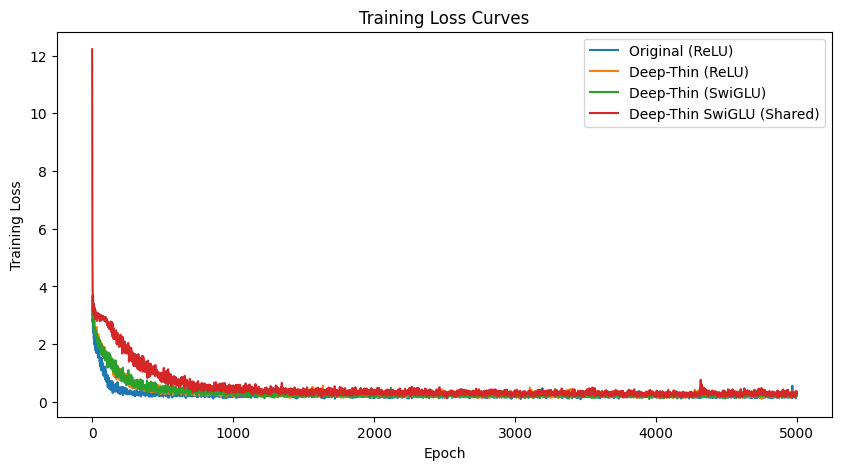

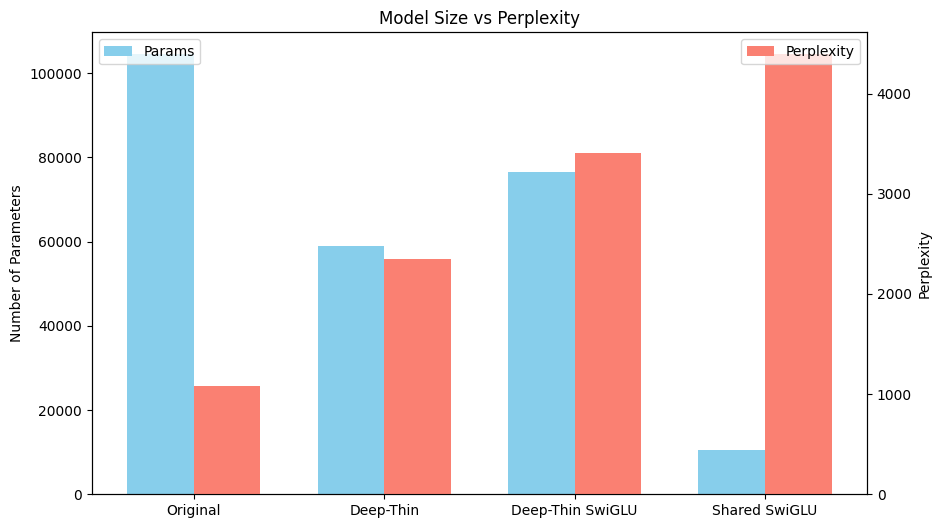


Generated by Original Mini-GPT:
 Alice who  would explore the foressaadventures. Every day, she would explore the would explore the foresso

Generated by Deep-and-Thin GPT:
 Alice who loved advent, shere would mblenamed upon a mystecerious. One and mbled upon a mysterious ging gi

Generated by Deep-and-Thin GPT (SwiGLU):
 Alice who loved adventures. Every day, she would explore the forest, discoveriscovering new secrets and ma

Generated by Deep-and-Thin SwiGLU (Shared):
 Alice who loved adventures. Every day, she would explore the forest, diiscovering new secrets and magical 


In [3]:
# ================================
# Compare Mini-GPT variants with Shared Embedding and Layer Sharing
# ================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

# ------------------
# 1️⃣ Set seeds
# ------------------
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ------------------
# 2️⃣ Sample story dataset
# ------------------
story_text = (
    "Once upon a time, in a land far away, there was a small village. "
    "In this village, lived a young girl named Alice who loved adventures. "
    "Every day, she would explore the forest, discovering new secrets and magical creatures. "
    "One day, she stumbled upon a mysterious door hidden behind the trees."
)

chars = sorted(list(set(story_text)))
vocab_size = len(chars)
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(stoi)}

def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return "".join([itos[i] for i in l])

data = torch.tensor(encode(story_text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# ------------------
# 3️⃣ Data loader
# ------------------
def get_batch(data, batch_size, block_size):
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# ------------------
# 4️⃣ Transformer building blocks
# ------------------
class Head(nn.Module):
    def __init__(self, head_size, embedding_dim, block_size):
        super().__init__()
        self.key = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.value = nn.Linear(embedding_dim, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, embedding_dim, dropout, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, embedding_dim, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads*head_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, embedding_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4*embedding_dim),
            nn.ReLU(),
            nn.Linear(4*embedding_dim, embedding_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, embedding_dim, n_heads, dropout, block_size):
        super().__init__()
        head_size = embedding_dim // n_heads
        self.sa = MultiHeadAttention(n_heads, head_size, embedding_dim, dropout, block_size)
        self.ffwd = FeedForward(embedding_dim, dropout)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# ------------------
# SwiGLU Implementation
# ------------------
class SwiGLU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.w1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.v = nn.Linear(hidden_dim, input_dim, bias=False)

    def forward(self, x):
        return self.v(self.w1(x) * torch.sigmoid(self.w2(x)))

class FeedForwardSwiGLU(nn.Module):
    def __init__(self, embedding_dim, dropout):
        super().__init__()
        hidden_dim = embedding_dim * 4
        self.net = nn.Sequential(
            SwiGLU(embedding_dim, hidden_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class BlockSwiGLU(nn.Module):
    def __init__(self, embedding_dim, n_heads, dropout, block_size):
        super().__init__()
        head_size = embedding_dim // n_heads
        self.sa = MultiHeadAttention(n_heads, head_size, embedding_dim, dropout, block_size)
        self.ffwd = FeedForwardSwiGLU(embedding_dim, dropout)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# ------------------
# 5️⃣ GPT Classes
# ------------------
class MiniGPT(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding_table = nn.Embedding(block_size, embedding_dim)
        self.blocks = nn.Sequential(*[Block(embedding_dim, n_heads, dropout, block_size) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, vocab_size)
        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        idx = idx.to(torch.long)
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_idx), dim=1)
        return idx

class MiniGPTSwiGLU(MiniGPT):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__(vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout)
        self.blocks = nn.Sequential(*[
            BlockSwiGLU(embedding_dim, n_heads, dropout, block_size) for _ in range(n_layers)
        ])

# ------------------
# 6️⃣ Deep-and-Thin SwiGLU with Embedding & Layer Sharing
# ------------------
class MiniGPTSwiGLU_Shared(MiniGPT):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__(vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout)
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)
        shared_block = BlockSwiGLU(embedding_dim, n_heads, dropout, block_size)
        self.blocks = nn.ModuleList([shared_block for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, vocab_size, bias=False)
        self.lm_head.weight = self.token_embedding_table.weight
        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        idx = idx.to(torch.long)
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

# ------------------
# 7️⃣ Training helper
# ------------------
def train_model(model_class, config, train_data, val_data, epochs=200):
    model = model_class(
        vocab_size=vocab_size,
        embedding_dim=config['embedding_dim'],
        n_layers=config['n_layers'],
        n_heads=config['n_heads'],
        block_size=config['block_size'],
        dropout=config['dropout']
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    train_losses = []
    for epoch in range(epochs):
        xb, yb = get_batch(train_data, config['batch_size'], config['block_size'])
        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss {loss.item():.4f}")
    # Validation
    xb, yb = get_batch(val_data, config['batch_size'], config['block_size'])
    with torch.no_grad():
        _, val_loss = model(xb, yb)
    perplexity = torch.exp(val_loss).item()
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return model, train_losses, val_loss.item(), perplexity, param_count

# ------------------
# 8️⃣ Configs
# ------------------
block_size = 16
dropout = 0.1
batch_size = 8
lr = 1e-2
epochs = 5000

original_config = {
    'embedding_dim': 64,
    'n_layers': 2,
    'n_heads': 4,
    'block_size': block_size,
    'dropout': dropout,
    'batch_size': batch_size,
    'lr': lr
}

deepthin_config = {
    'embedding_dim': 24,
    'n_layers': 8,
    'n_heads': 2,
    'block_size': block_size,
    'dropout': dropout,
    'batch_size': batch_size,
    'lr': lr
}

# ------------------
# 9️⃣ Train models
# ------------------
print("Training Original Mini-GPT...")
orig_model, orig_losses, orig_val_loss, orig_ppl, orig_params = train_model(MiniGPT, original_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin Mini-GPT...")
deep_model, deep_losses, deep_val_loss, deep_ppl, deep_params = train_model(MiniGPT, deepthin_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin Mini-GPT (SwiGLU)...")
deep_swiglu_model, deep_swiglu_losses, deep_swiglu_val_loss, deep_swiglu_ppl, deep_swiglu_params = train_model(MiniGPTSwiGLU, deepthin_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin SwiGLU (Shared)...")
shared_model, shared_losses, shared_val_loss, shared_ppl, shared_params = train_model(MiniGPTSwiGLU_Shared, deepthin_config, train_data, val_data, epochs)

# ------------------
# 10️⃣ Compare metrics
# ------------------
print("\n===== Comparison =====")
print(f"Original Mini-GPT: Val Loss={orig_val_loss:.4f}, Perplexity={orig_ppl:.4f}, Params={orig_params}")
print(f"Deep-and-Thin GPT: Val Loss={deep_val_loss:.4f}, Perplexity={deep_ppl:.4f}, Params={deep_params}")
print(f"Deep-and-Thin GPT (SwiGLU): Val Loss={deep_swiglu_val_loss:.4f}, Perplexity={deep_swiglu_ppl:.4f}, Params={deep_swiglu_params}")
print(f"Deep-and-Thin SwiGLU (Shared): Val Loss={shared_val_loss:.4f}, Perplexity={shared_ppl:.4f}, Params={shared_params}")

# ------------------
# 11️⃣ Plot training curves
# ------------------
plt.figure(figsize=(10,5))
plt.plot(orig_losses, label='Original (ReLU)')
plt.plot(deep_losses, label='Deep-Thin (ReLU)')
plt.plot(deep_swiglu_losses, label='Deep-Thin (SwiGLU)')
plt.plot(shared_losses, label='Deep-Thin SwiGLU (Shared)')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss Curves')
plt.show()

# ------------------
# 12️⃣ Bar chart: Model Size vs Perplexity
# ------------------
models = ['Original', 'Deep-Thin', 'Deep-Thin SwiGLU', 'Shared SwiGLU']
params = [orig_params, deep_params, deep_swiglu_params, shared_params]
ppls = [orig_ppl, deep_ppl, deep_swiglu_ppl, shared_ppl]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(x - width/2, params, width, color='skyblue', label='Params')
ax1.set_ylabel('Number of Parameters')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title('Model Size vs Perplexity')

ax2 = ax1.twinx()
ax2.bar(x + width/2, ppls, width, color='salmon', label='Perplexity')
ax2.set_ylabel('Perplexity')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# ------------------
# 13️⃣ Generate story continuation
# ------------------
prompt = "Alice "
context = torch.tensor(encode(prompt), dtype=torch.long, device=device).unsqueeze(0)

gen_orig = orig_model.generate(context, max_new_tokens=100)[0].tolist()
gen_deep = deep_model.generate(context, max_new_tokens=100)[0].tolist()
gen_swiglu = deep_swiglu_model.generate(context, max_new_tokens=100)[0].tolist()
gen_shared = shared_model.generate(context, max_new_tokens=100)[0].tolist()

print("\nGenerated by Original Mini-GPT:\n", decode(gen_orig))
print("\nGenerated by Deep-and-Thin GPT:\n", decode(gen_deep))
print("\nGenerated by Deep-and-Thin GPT (SwiGLU):\n", decode(gen_swiglu))
print("\nGenerated by Deep-and-Thin SwiGLU (Shared):\n", decode(gen_shared))
